# Interactively display images and guess if they're show cancer / healthy tissue

This kernel allows to browse through randomly selected images on at a time.  
First you see the image without label and you can try to 'classify' it.  
Then you'll see the image with label and check if you were correct.

Spoiler: Even the most basic CNN will probably beat you :-)

In [1]:
import os

import numpy as np
from numpy.random import choice
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import ImageDraw, ImageFont, Image

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

import torch
from torchvision import transforms
import torchvision

In [2]:
DATA_DIR = '../input'

train_dir = os.path.join(DATA_DIR, 'train')
label_df = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))    

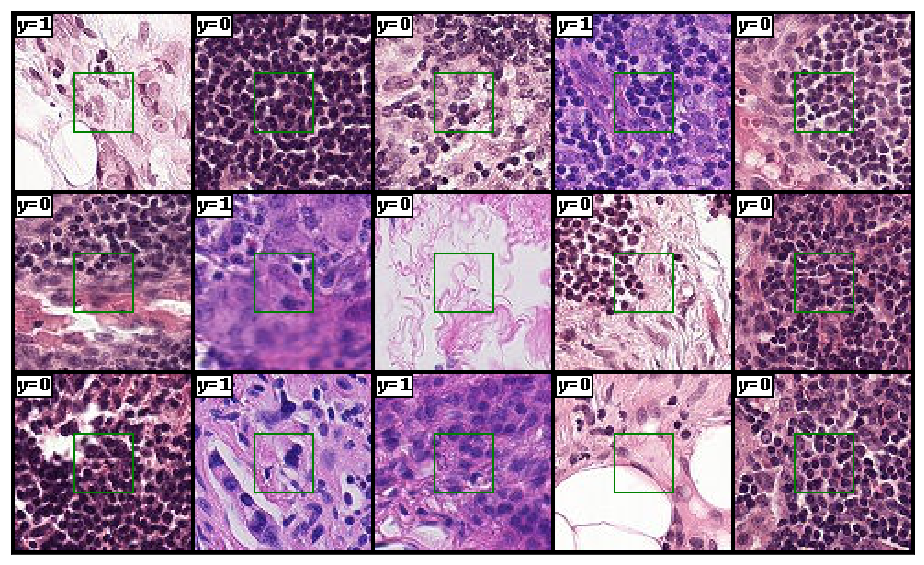

In [3]:
def annotate_image(image: Image, text: str):
    draw = ImageDraw.Draw(image)
    draw.rectangle(((0, 0), (20, 12)), fill='white', outline='black')
    draw.text((2, 0), text, fill='black')
    return image


def sample_images(data_dir: str, files=None, n=15, label_df=None, box=True, return_img=False):
    
    if files is None:
        files = choice(os.listdir(data_dir), size=n)
        
    images = []
    for filename in files:
        img = Image.open(os.path.join(train_dir, filename))
        
        if label_df is not None:
            id_   = filename.split('.')[0]
            label = label_df.query('id == @id_').label.item()
            img   = annotate_image(img, f'y={label}')
        
        if box:
            draw = ImageDraw.Draw(img)
            draw.rectangle(((32, 32), (64, 64)), outline='green')
            
        images.append(img)

    tensors = list(map(transforms.ToTensor(), images))
    tensor  = torch.stack(tensors)
    grid    = torchvision.utils.make_grid(tensor, nrow=n//int(np.ceil(n/5)))
    
    if return_img:
        return grid
    
    plt.figure(figsize=(24, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([]);
    plt.show()

sample_images(data_dir=train_dir, n=15, label_df=label_df, box=True)

In [4]:
def guess_label(n=10):
    images = []
    for _ in range(n):
        file = choice(os.listdir(train_dir))  # raw and labeled version of the same image
        raw = sample_images(train_dir, files=[file], label_df=None, return_img=True)
        labeled = sample_images(train_dir, files=[file], label_df=label_df, return_img=True)
        images.extend([raw, labeled])  # order: raw, labeld, raw, ....

    def show_image(i):
        plt.figure(figsize=(24, 10))
        plt.imshow(images[i].permute(1, 2, 0))
        plt.grid(False)
        plt.xticks([])
        plt.yticks([]);
        plt.show()    

    return interactive(show_image, i=(0, (n*2)-1))

## Instruction

Just move the slider to the left and start scrolling through the images.

You'll see the unlabled image first and the labeled image next.  
Then, the next unlabeld image is shown and so on...

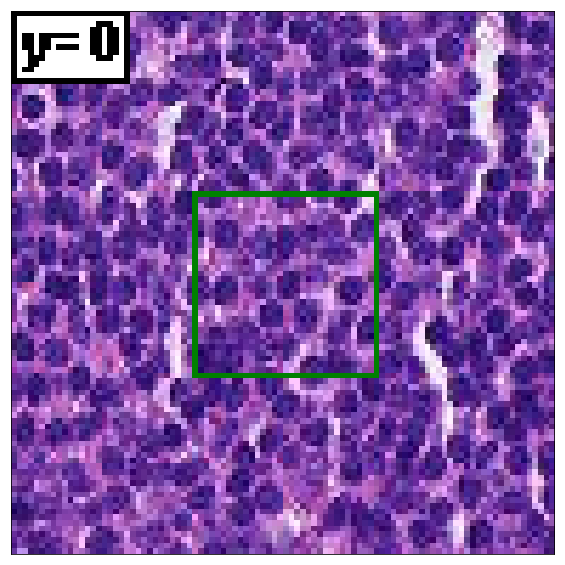

In [5]:
guess_label(n=10)